# Importing libraries
### Done by Gabriel, Colby, Heejun

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc
# import preprocessing classes
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# feature selection
from sklearn.feature_selection import chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, chi2

# import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# import train test split
from sklearn.model_selection import train_test_split

# feature importance
from sklearn.inspection import permutation_importance

# import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# functions to save data
from joblib import dump, load

# read data
## mount google drive
from google.colab import drive
drive.mount("/content/drive/")
%cd '/content/drive/MyDrive/DS440/dataset/Data/'
!pwd

## read in files
dir = '/content/drive/MyDrive/DS440/dataset/Data/'
cnx = sqlite3.connect(dir + 'wildfire.sqlite')
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='Fires';")
tables = cursor.fetchall()
Fires = pd.read_sql_query("SELECT * FROM 'Fires'", cnx).set_index('FOD_ID')
gc.collect()
# Drop unnecessary column
Fires.drop(columns=['FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID',
                    'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
                    'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID',
                    'MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','OWNER_DESCR','NWCG_CAUSE_CLASSIFICATION',
                    'NWCG_CAUSE_AGE_CATEGORY','CONT_TIME','CONT_DATE'],inplace=True)

Mounted at /content/drive/
/content/drive/MyDrive/DS440/dataset/Data
/content/drive/MyDrive/DS440/dataset/Data


In [4]:
Fires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
FOD_ID,,,,,,,,,,,,,,
1,2005,2/2/2005 0:00,33,1300.0,Power generation/transmission/distribution,33.0,0.10,A,40.036944,-121.005833,CA,63,06063,Plumas County
2,2004,5/12/2004 0:00,133,845.0,Natural,133.0,0.25,A,38.933056,-120.404444,CA,61,06061,Placer County
3,2004,5/31/2004 0:00,152,1921.0,Debris and open burning,152.0,0.10,A,38.984167,-120.735556,CA,17,06017,El Dorado County
4,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.913333,CA,3,06003,Alpine County
5,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.933056,CA,3,06003,Alpine County


# Data Preprocessing
## convert all features into usable format
## Use random sample from originial dataset due to high computational cost
## Take 5% of original data
## Purpose : 
1. To handle big data
2. To debug and to see that the code actually works

In [5]:
# Later just remove this line of code when using original dataset
Fires = Fires.sample(frac=0.01,replace=False)

In [6]:
Fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
FOD_ID,,,,,,,,,,,,,,
300115089,2014,5/4/2014 0:00,124,45.0,Arson/incendiarism,124.0,109.00,D,35.831120,-92.859090,AR,SEARCY,05129,Searcy County
300005109,2014,8/1/2014 0:00,213,2159.0,Natural,214.0,0.50,B,44.293333,-119.333333,OR,Grant,41023,Grant County
260695,2000,3/7/2000 0:00,67,1708.0,Debris and open burning,67.0,1.00,B,46.394400,-100.589600,ND,None,None,None
592266,1995,5/30/1995 0:00,150,NaN,Arson/incendiarism,NaN,0.25,A,39.545830,-74.975000,NJ,Atlantic,34001,Atlantic County
346216,2008,7/21/2008 0:00,203,1503.0,Equipment and vehicle use,203.0,1.50,B,41.875000,-118.588600,NV,Humboldt,32013,Humboldt County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144752,1995,1/27/1995 0:00,27,NaN,Missing data/not specified/undetermined,NaN,11.00,C,35.041700,-79.145000,NC,None,None,None
1272286,2000,7/10/2000 0:00,192,1645.0,Natural,192.0,0.10,A,46.551944,-113.483611,MT,039,30039,Granite County
1133117,1993,9/21/1993 0:00,264,NaN,Equipment and vehicle use,NaN,0.10,A,35.005000,-80.075000,NC,None,None,None


# Colby's Coding

In [7]:
# extract month from discovery date
def get_first_element(date_list):
  return date_list[0]

Fires['DISCOVERY_DATE'] = Fires['DISCOVERY_DATE'].astype("string")
Fires['DISCOVERY_LIST'] = Fires['DISCOVERY_DATE'].str.split(pat='/')
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_LIST'].map(get_first_element)
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_MONTH'].astype("int64")

# encode causes into integers
Fires['NWCG_GENERAL_CAUSE'] = Fires['NWCG_GENERAL_CAUSE'].astype("string")
cause_enc = LabelEncoder()
Fires['NWCG_CAUSE_CLASSIFICATION_ORD'] = cause_enc.fit_transform(Fires['NWCG_GENERAL_CAUSE'])


# figure out number of days to contain the fire
Fires['DAYS_TO_CONT'] = Fires['CONT_DOY'] - Fires['DISCOVERY_DOY']
##### if it was contained the next year, need to do something about that
def convert_negative_days(day):
  if day < 0:
    return 365 + day
  else:
    return day

Fires['DAYS_TO_CONT'] = Fires['DAYS_TO_CONT'].map(convert_negative_days)


# encode state categories into integers
Fires['STATE'] = Fires['STATE'].astype("string")
state_enc = LabelEncoder()
Fires['STATE_ORD'] = state_enc.fit_transform(Fires['STATE'])

# what to do about counties? Use fips code (must be an int)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("string")
Fires['FIPS_CODE'].fillna('1000000',inplace=True)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("int64")

# fill NA with mean of day to containment (mean = 0.92)
Fires['DAYS_TO_CONT'].fillna(value=Fires['DAYS_TO_CONT'].mean(),inplace=True)


# drop date and list
Fires.drop(columns=['DISCOVERY_DATE','DISCOVERY_LIST','NWCG_GENERAL_CAUSE',
                    'CONT_DOY','DISCOVERY_DOY','STATE','FIPS_NAME',
                    'COUNTY'],inplace=True)
gc.collect()

19

In [8]:
Fires.head()

,FIRE_YEAR,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
FOD_ID,,,,,,,,,,,
300115089,2014,45.0,109.00,D,35.831120,-92.859090,5129,5,0,0.000000,2
300005109,2014,2159.0,0.50,B,44.293333,-119.333333,41023,8,7,1.000000,36
260695,2000,1708.0,1.00,B,46.394400,-100.589600,1000000,3,1,0.000000,27
592266,1995,NaN,0.25,A,39.545830,-74.975000,34001,5,0,1.035553,30
346216,2008,1503.0,1.50,B,41.875000,-118.588600,32013,7,2,0.000000,32


In [9]:
#Replace NaN with values predicted by KNN
from sklearn.impute import KNNImputer
Fires_KNN = Fires.sample(frac=1,random_state=0)
Input = Fires_KNN[['FIRE_YEAR','DISCOVERY_TIME','FIRE_SIZE','LATITUDE','LONGITUDE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD']]
imputer = KNNImputer(n_neighbors=10)

In [10]:
result = imputer.fit_transform(Input)
check = pd.DataFrame(result)
New_Discovery_Time = check[[1]].values.tolist()

In [11]:
Fires_KNN['Assumption'] = New_Discovery_Time
# Convert object to float64
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("string")
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].str.strip('[]')
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("float64")
# Drop DISCOVERY_TIME column that contains NaN
Fires_KNN.drop(columns=['DISCOVERY_TIME'],inplace=True)
# Change column name from Assumption to DISCOVERY_TIME
Fires_KNN['DISCOVERY_TIME'] = Fires_KNN['Assumption']
Fires_KNN.drop(columns=['Assumption'],inplace=True)
Fires_KNN

,FIRE_YEAR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD,DISCOVERY_TIME
FOD_ID,,,,,,,,,,,
400159688,2017,10.00,C,36.276770,-93.421430,1000000,2,5,1.035553,2,1392.4
546066,2002,0.10,A,47.439979,-92.924442,27137,4,0,1.035553,22,1678.6
400418966,2008,0.10,A,34.085162,-117.704443,6071,6,0,1.035553,4,2349.0
400176692,2017,0.10,A,38.914761,-98.762364,20167,2,2,0.000000,15,1443.0
1018009,2000,50.00,C,30.546700,-92.901700,1000000,2,5,1.035553,17,1155.6
...,...,...,...,...,...,...,...,...,...,...,...
1763047,2008,0.43,B,42.467396,-78.477871,36009,4,5,0.000000,33,1618.0
1771252,2007,0.50,B,44.400793,-73.664258,36031,6,7,0.000000,33,1630.0
1433728,2010,0.65,B,42.552500,-122.255556,41029,7,7,0.000000,36,850.0


# ** Code by Heejun **
## Feature selection information
Later need to convert LONGITUDE to negative values!!

Reason for using abs() : There are no positive values !!
                        
(United States only have negative lonitude values)

In [12]:
# Convert negative value to positive
# Feature Selection must have non-negative values
Fires_KNN['LONGITUDE'] = Fires_KNN['LONGITUDE'].abs()

from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing

X_KNN = Fires_KNN[['FIRE_YEAR','LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_KNN = Fires_KNN['FIRE_SIZE']
# Transform FIRE_SIZE
# SelectKBest() cannot handle countinous numbers
Encoder_KNN = preprocessing.LabelEncoder()
Firs_size_encoded_KNN = Encoder_KNN.fit_transform(y_KNN)

Best_Features_KNN = dict()
for i in range(1,9):
  selector_KNN = SelectKBest(chi2, k=i)
  selector_KNN.fit(X_KNN, Firs_size_encoded_KNN)
  Features_KNN = list(X_KNN.columns[selector_KNN.get_support(indices=True)])
  Best_Features_KNN[i] = Features_KNN
  print("(KNN) When k= ", i, ",", Features_KNN)

(KNN) When k=  1 , ['FIPS_CODE']
(KNN) When k=  2 , ['FIPS_CODE', 'DAYS_TO_CONT']
(KNN) When k=  3 , ['FIPS_CODE', 'DAYS_TO_CONT', 'DISCOVERY_TIME']
(KNN) When k=  4 , ['FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  5 , ['LONGITUDE', 'FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  6 , ['LONGITUDE', 'FIPS_CODE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  7 , ['LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']
(KNN) When k=  8 , ['LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'DISCOVERY_MONTH', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']


# With missing values(NaN), models cannot be trained!

Below code will show the error!

In [13]:
#### split data into training, validation, and testing
X = Fires[['FIRE_YEAR','LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y = Fires['FIRE_SIZE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#### List of models
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR] #GaussianNB, 
################################################################################################################################               
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print("MSE = ", model_mse, '\n', "MAE = ", model_mae)

<class 'sklearn.linear_model._base.LinearRegression'>


ValueError: ignored

# MODEL

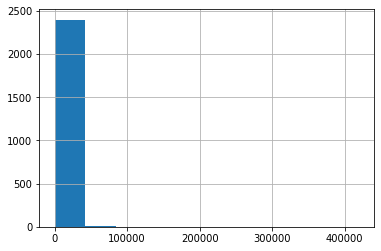

In [14]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 15]['FIRE_SIZE'].hist()

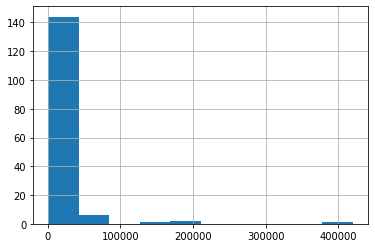

In [15]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 1000]['FIRE_SIZE'].hist()

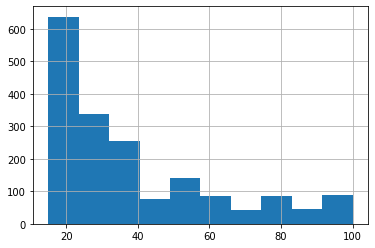

In [16]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(15,100)]['FIRE_SIZE'].hist()

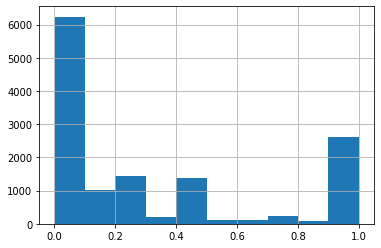

In [17]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(0,1)]['FIRE_SIZE'].hist()

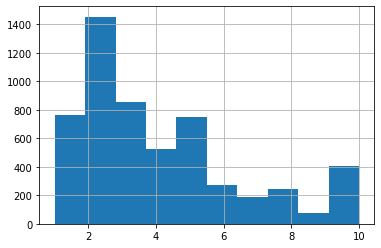

In [18]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1.01,10)]['FIRE_SIZE'].hist()

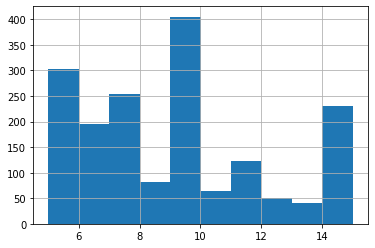

In [19]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(5.01,15)]['FIRE_SIZE'].hist()

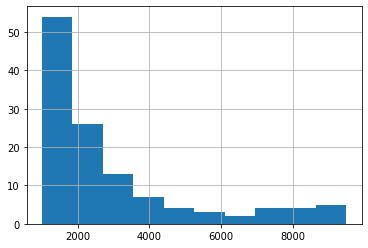

In [20]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1000,10000)]['FIRE_SIZE'].hist()

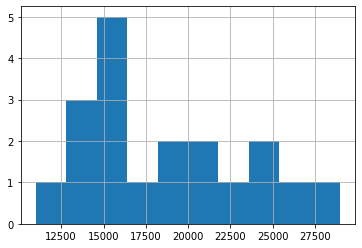

In [21]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,30000)]['FIRE_SIZE'].hist()

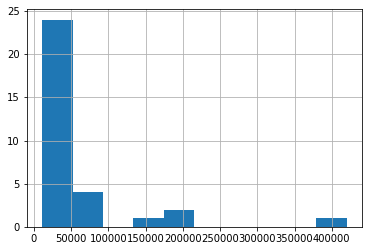

In [22]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,333330000)]['FIRE_SIZE'].hist()

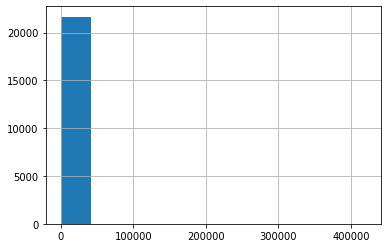

In [23]:
Fires['FIRE_SIZE'].hist()

# Trial 1
  - Use all data to predict fire size

## Create the baseline
 - Use all the data to predict fire size in year 2018

In [24]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [25]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,1.435588e+05,35.522338
0,<class 'sklearn.linear_model._base.LinearRegre...,3.676772e+05,205.872213
1,<class 'sklearn.ensemble._forest.RandomForestR...,4.436791e+05,100.594039
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,4.576790e+05,88.767056
3,<class 'sklearn.neighbors._regression.KNeighbo...,2.523285e+06,154.910948
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.848968e+06,702.532316


## Use ensemble method

In [26]:
from sklearn.ensemble import VotingRegressor
# Models
r1_t1 = LinearRegression()
r2_t1 = RandomForestRegressor()
r3_t1 = GradientBoostingRegressor()
r4_t1 = AdaBoostRegressor()
r5_t1 = KNeighborsRegressor()
r6_t1 = SVR()
# Possible ensembles
est_t1c1=[('reg1', r1_t1), ('reg2', r2_t1)]
est_t1c2=[('reg1', r1_t1), ('reg3', r3_t1)]
est_t1c3=[('reg1', r1_t1), ('reg4', r4_t1)]
est_t1c4=[('reg1', r1_t1), ('reg5', r5_t1)]
est_t1c5=[('reg1', r1_t1), ('reg6', r6_t1)]
est_t1c6=[('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c7=[('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c8=[('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c9=[('reg2', r2_t1), ('reg6', r6_t1)]
est_t1c10=[('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c11=[('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c12=[('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c13=[('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c14=[('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c15=[('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c16=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c17=[('reg1', r1_t1), ('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c18=[('reg1', r1_t1), ('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c19=[('reg1', r1_t1), ('reg2', r2_t1), ('reg6', r6_t1)]
est_t1c20=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c21=[('reg1', r1_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c22=[('reg1', r1_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c23=[('reg1', r1_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c24=[('reg1', r1_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c25=[('reg1', r1_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c26=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c27=[('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c28=[('reg2', r2_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c29=[('reg2', r2_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c30=[('reg2', r2_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c31=[('reg2', r2_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c32=[('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c33=[('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c34=[('reg3', r3_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c35=[('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c36=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c37=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c38=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg6', r6_t1)]
est_t1c39=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c40=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c41=[('reg1', r1_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c42=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c43=[('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c44=[('reg2', r2_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c45=[('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c46=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c47=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg6', r6_t1)]
est_t1c48=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c49=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
est_t1c50=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1), ('reg6', r6_t1)]
ens_list = [est_t1c1,est_t1c2,est_t1c3,est_t1c4,est_t1c5,est_t1c6,est_t1c7,est_t1c8,est_t1c9,est_t1c10,
            est_t1c11,est_t1c12,est_t1c13,est_t1c14,est_t1c15,est_t1c16,est_t1c17,est_t1c18,est_t1c19,est_t1c20,
            est_t1c21,est_t1c22,est_t1c23,est_t1c24,est_t1c25,est_t1c26,est_t1c27,est_t1c28,est_t1c29,est_t1c30,
            est_t1c31,est_t1c32,est_t1c33,est_t1c34,est_t1c35,est_t1c36,est_t1c37,est_t1c38,est_t1c39,est_t1c40,
            est_t1c41,est_t1c42,est_t1c43,est_t1c44,est_t1c45,est_t1c46,est_t1c47,est_t1c48,est_t1c49,est_t1c50]

model_ens_t1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t1 = VotingRegressor(i).fit(X_KNN_train,X_KNN_test)
  # Predict with our ensemble model
  ensemble_t1_pred = ensemble_t1.predict(y_KNN_train)
  model_ens_t1_mse = mean_squared_error(ensemble_t1_pred,y_KNN_test)
  model_ens_t1_mae = mean_absolute_error(ensemble_t1_pred,y_KNN_test)
  model_scores_ens_t1 = (ensemble_t1,y_KNN_test,ensemble_t1_pred)
  model_ens_t1_df = model_ens_t1_df.append({'Model':i,'MSE':model_ens_t1_mse,'MAE':model_ens_t1_mae}, ignore_index=True)
  model_ens_t1_df = model_ens_t1_df.sort_values(by='MSE', ascending= True)
model_ens_t1_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg6, SVR())]",155232.591262,117.971893
1,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",173533.824748,65.119243
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",177560.133365,58.969831
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",191913.784785,108.551950
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",192043.426070,100.153885


# Trial 2 (Divide dataset by fire size)
  - Division number: 10

- 1st Division (Fire Size < 1)

  - GradientBoostingRegressor outperformed!

In [27]:
# 1st Division (Fire Size < 1)
Fires_t2_div1 = Fires_KNN[Fires_KNN['FIRE_SIZE'] <= 1]
XT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [28]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d1 = dict()       
model_T2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d1 = model().fit(XT2d1_train,XT2d1_test)
  y_T2d1_pred = regressor_T2d1.predict(yT2d1_train)
  model_T2d1_mse = mean_squared_error(y_T2d1_pred,yT2d1_test)
  model_T2d1_mae = mean_absolute_error(y_T2d1_pred,yT2d1_test)
  model_scores_T2d1[model] = (regressor_T2d1,yT2d1_test,y_T2d1_pred)
  model_T2d1_df = model_T2d1_df.append({'Model':model,'MSE':model_T2d1_mse,'MAE':model_T2d1_mae}, ignore_index=True)
  model_T2d1_df = model_T2d1_df.sort_values(by='MSE', ascending= True)
model_T2d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,0.107228,0.247309
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.108162,0.263872
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.112793,0.291295
3,<class 'sklearn.neighbors._regression.KNeighbo...,0.119682,0.255242
4,<class 'sklearn.linear_model._base.LinearRegre...,0.119937,0.297943
5,<class 'sklearn.svm._classes.SVR'>,0.132431,0.254223


In [29]:
# Ensemble method
model_ens_t2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d1 = VotingRegressor(i).fit(XT2d1_train,XT2d1_test)
  # Predict with our ensemble model
  ensemble_t2d1_pred = ensemble_t2d1.predict(yT2d1_train)
  model_ens_t2d1_mse = mean_squared_error(ensemble_t2d1_pred,yT2d1_test)
  model_ens_t2d1_mae = mean_absolute_error(ensemble_t2d1_pred,yT2d1_test)
  model_scores_ens_t2d1 = (ensemble_t2d1,yT2d1_test,ensemble_t2d1_pred)
  model_ens_t2d1_df = model_ens_t2d1_df.append({'Model':i,'MSE':model_ens_t2d1_mse,'MAE':model_ens_t2d1_mae}, ignore_index=True)
  model_ens_t2d1_df = model_ens_t2d1_df.sort_values(by='MSE', ascending= True)
model_ens_t2d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.101954,0.245785
1,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",0.103136,0.242752
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.103194,0.247451
3,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.103377,0.253746
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.103760,0.256047


- 2nd Division (1<= Fire Size <= 2)

  - GradientBoostingRegressor outperformed!

In [30]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t2_div2 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] >= 1) & (Fires_KNN['FIRE_SIZE'] <= 2)]
XT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [31]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d2 = dict()       
model_T2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d2 = model().fit(XT2d2_train,XT2d2_test)
  y_T2d2_pred = regressor_T2d2.predict(yT2d2_train)
  model_T2d2_mse = mean_squared_error(y_T2d2_pred,yT2d2_test)
  model_T2d2_mae = mean_absolute_error(y_T2d2_pred,yT2d2_test)
  model_scores_T2d2[model] = (regressor_T2d2,yT2d2_test,y_T2d2_pred)
  model_T2d2_df = model_T2d2_df.append({'Model':model,'MSE':model_T2d2_mse,'MAE':model_T2d2_mae}, ignore_index=True)
  model_T2d2_df = model_T2d2_df.sort_values(by='MSE', ascending= True)
model_T2d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.170949,0.375834
1,<class 'sklearn.linear_model._base.LinearRegre...,0.176840,0.389140
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.183626,0.405078
5,<class 'sklearn.svm._classes.SVR'>,0.191247,0.290239
3,<class 'sklearn.neighbors._regression.KNeighbo...,0.205901,0.398593
4,<class 'sklearn.ensemble._forest.RandomForestR...,0.210275,0.410381


In [32]:
# Ensemble method
model_ens_t2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d2 = VotingRegressor(i).fit(XT2d2_train,XT2d2_test)
  # Predict with our ensemble model
  ensemble_t2d2_pred = ensemble_t2d2.predict(yT2d2_train)
  model_ens_t2d2_mse = mean_squared_error(ensemble_t2d2_pred,yT2d2_test)
  model_ens_t2d2_mae = mean_absolute_error(ensemble_t2d2_pred,yT2d2_test)
  model_scores_ens_t2d2 = (ensemble_t2d2,yT2d2_test,ensemble_t2d2_pred)
  model_ens_t2d2_df = model_ens_t2d2_df.append({'Model':i,'MSE':model_ens_t2d2_mse,'MAE':model_ens_t2d2_mae}, ignore_index=True)
  model_ens_t2d2_df = model_ens_t2d2_df.sort_values(by='MSE', ascending= True)
model_ens_t2d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.166109,0.350503
1,"[(reg3, GradientBoostingRegressor()), (reg6, S...",0.166138,0.332263
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.167052,0.356972
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",0.167586,0.354010
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.167615,0.354114


- 3rd Division (2< Fire Size <= 5)

  - GradientBoostingRegressor outperformed!

In [33]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t2_div3 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 2) & (Fires_KNN['FIRE_SIZE'] <= 5)]
XT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [34]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d3 = dict()       
model_T2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d3 = model().fit(XT2d3_train,XT2d3_test)
  y_T2d3_pred = regressor_T2d3.predict(yT2d3_train)
  model_T2d3_mse = mean_squared_error(y_T2d3_pred,yT2d3_test)
  model_T2d3_mae = mean_absolute_error(y_T2d3_pred,yT2d3_test)
  model_scores_T2d3[model] = (regressor_T2d3,yT2d3_test,y_T2d3_pred)
  model_T2d3_df = model_T2d3_df.append({'Model':model,'MSE':model_T2d3_mse,'MAE':model_T2d3_mae}, ignore_index=True)
  model_T2d3_df = model_T2d3_df.sort_values(by='MSE', ascending= True)
model_T2d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.937293,0.877910
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.950874,0.887049
2,<class 'sklearn.ensemble._forest.RandomForestR...,0.979097,0.875350
3,<class 'sklearn.neighbors._regression.KNeighbo...,0.990902,0.851267
4,<class 'sklearn.linear_model._base.LinearRegre...,1.075150,0.947936
5,<class 'sklearn.svm._classes.SVR'>,1.096202,0.964988


In [35]:
# Ensemble method
model_ens_t2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d3 = VotingRegressor(i).fit(XT2d3_train,XT2d3_test)
  # Predict with our ensemble model
  ensemble_t2d3_pred = ensemble_t2d3.predict(yT2d3_train)
  model_ens_t2d3_mse = mean_squared_error(ensemble_t2d3_pred,yT2d3_test)
  model_ens_t2d3_mae = mean_absolute_error(ensemble_t2d3_pred,yT2d3_test)
  model_scores_ens_t2d3 = (ensemble_t2d3,yT2d3_test,ensemble_t2d3_pred)
  model_ens_t2d3_df = model_ens_t2d3_df.append({'Model':i,'MSE':model_ens_t2d3_mse,'MAE':model_ens_t2d3_mae}, ignore_index=True)
  model_ens_t2d3_df = model_ens_t2d3_df.sort_values(by='MSE', ascending= True)
model_ens_t2d3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.931742,0.870344
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.936753,0.880672
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",0.939194,0.854035
3,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.941434,0.882750
4,"[(reg3, GradientBoostingRegressor()), (reg5, K...",0.941695,0.862014


- 4th Division (5< Fire Size <= 15)

  - LinearRegression outperformed!

In [36]:
# 4th Division (5 < Fire Size <= 15)
Fires_t2_div4 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 5) & (Fires_KNN['FIRE_SIZE'] <= 15)]
XT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [37]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d4 = dict()       
model_T2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d4 = model().fit(XT2d4_train,XT2d4_test)
  y_T2d4_pred = regressor_T2d4.predict(yT2d4_train)
  model_T2d4_mse = mean_squared_error(y_T2d4_pred,yT2d4_test)
  model_T2d4_mae = mean_absolute_error(y_T2d4_pred,yT2d4_test)
  model_scores_T2d4[model] = (regressor_T2d4,yT2d4_test,y_T2d4_pred)
  model_T2d4_df = model_T2d4_df.append({'Model':model,'MSE':model_T2d4_mse,'MAE':model_T2d4_mae}, ignore_index=True)
  model_T2d4_df = model_T2d4_df.sort_values(by='MSE', ascending= True)
model_T2d4_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,9.770824,2.674737
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,9.784124,2.644708
1,<class 'sklearn.ensemble._forest.RandomForestR...,9.915211,2.675276
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,9.989570,2.744769
3,<class 'sklearn.linear_model._base.LinearRegre...,10.169888,2.804764
4,<class 'sklearn.neighbors._regression.KNeighbo...,13.305982,2.960480


In [38]:
# Ensemble method
model_ens_t2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d4 = VotingRegressor(i).fit(XT2d4_train,XT2d4_test)
  # Predict with our ensemble model
  ensemble_t2d4_pred = ensemble_t2d4.predict(yT2d4_train)
  model_ens_t2d4_mse = mean_squared_error(ensemble_t2d4_pred,yT2d4_test)
  model_ens_t2d4_mae = mean_absolute_error(ensemble_t2d4_pred,yT2d4_test)
  model_scores_ens_t2d4 = (ensemble_t2d4,yT2d4_test,ensemble_t2d4_pred)
  model_ens_t2d4_df = model_ens_t2d4_df.append({'Model':i,'MSE':model_ens_t2d4_mse,'MAE':model_ens_t2d4_mae}, ignore_index=True)
  model_ens_t2d4_df = model_ens_t2d4_df.sort_values(by='MSE', ascending= True)
model_ens_t2d4_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",9.532811,2.647203
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",9.633437,2.655306
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",9.664771,2.658735
3,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",9.671581,2.667228
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",9.690760,2.672337


- 5th Division (15< Fire Size <= 40)

  - GradientBoostingRegressor outperformed!

In [39]:
# 5th Division (15 < Fire Size <= 40)
Fires_t2_div5 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 15) & (Fires_KNN['FIRE_SIZE'] <= 40)]
XT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [40]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d5 = dict()       
model_T2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d5 = model().fit(XT2d5_train,XT2d5_test)
  y_T2d5_pred = regressor_T2d5.predict(yT2d5_train)
  model_T2d5_mse = mean_squared_error(y_T2d5_pred,yT2d5_test)
  model_T2d5_mae = mean_absolute_error(y_T2d5_pred,yT2d5_test)
  model_scores_T2d5[model] = (regressor_T2d5,yT2d5_test,y_T2d5_pred)
  model_T2d5_df = model_T2d5_df.append({'Model':model,'MSE':model_T2d5_mse,'MAE':model_T2d5_mae}, ignore_index=True)
  model_T2d5_df = model_T2d5_df.sort_values(by='MSE', ascending= True)
model_T2d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,61.645139,6.995904
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,62.904574,7.131643
2,<class 'sklearn.linear_model._base.LinearRegre...,64.604168,7.012736
5,<class 'sklearn.svm._classes.SVR'>,66.416882,6.997483
3,<class 'sklearn.ensemble._forest.RandomForestR...,66.508223,7.253860
4,<class 'sklearn.neighbors._regression.KNeighbo...,70.498244,6.954960


In [41]:
# Ensemble method
model_ens_t2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d5 = VotingRegressor(i).fit(XT2d5_train,XT2d5_test)
  # Predict with our ensemble model
  ensemble_t2d5_pred = ensemble_t2d5.predict(yT2d5_train)
  model_ens_t2d5_mse = mean_squared_error(ensemble_t2d5_pred,yT2d5_test)
  model_ens_t2d5_mae = mean_absolute_error(ensemble_t2d5_pred,yT2d5_test)
  model_scores_ens_t2d5 = (ensemble_t2d5,yT2d5_test,ensemble_t2d5_pred)
  model_ens_t2d5_df = model_ens_t2d5_df.append({'Model':i,'MSE':model_ens_t2d5_mse,'MAE':model_ens_t2d5_mae}, ignore_index=True)
  model_ens_t2d5_df = model_ens_t2d5_df.sort_values(by='MSE', ascending= True)
model_ens_t2d5_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg4, A...",59.100755,6.917254
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",61.105045,6.885528
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",61.610815,7.032572
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",61.706695,6.931118
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",62.065518,7.078277


- 6th Division (40< Fire Size <= 150)

  - AdaBoostRegressor outperformed!

In [42]:
# 6th Division (40 < Fire Size <= 150)
Fires_t2_div6 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 40) & (Fires_KNN['FIRE_SIZE'] <= 150)]
XT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [43]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d6 = dict()       
model_T2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d6 = model().fit(XT2d6_train,XT2d6_test)
  y_T2d6_pred = regressor_T2d6.predict(yT2d6_train)
  model_T2d6_mse = mean_squared_error(y_T2d6_pred,yT2d6_test)
  model_T2d6_mae = mean_absolute_error(y_T2d6_pred,yT2d6_test)
  model_scores_T2d6[model] = (regressor_T2d6,yT2d6_test,y_T2d6_pred)
  model_T2d6_df = model_T2d6_df.append({'Model':model,'MSE':model_T2d6_mse,'MAE':model_T2d6_mae}, ignore_index=True)
  model_T2d6_df = model_T2d6_df.sort_values(by='MSE', ascending= True)
model_T2d6_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,688.453344,22.922814
1,<class 'sklearn.linear_model._base.LinearRegre...,691.331739,21.921520
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,712.979423,23.345583
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,719.136182,23.331278
5,<class 'sklearn.svm._classes.SVR'>,844.828460,22.900697
4,<class 'sklearn.neighbors._regression.KNeighbo...,1052.766496,25.167643


In [44]:
# Ensemble method
model_ens_t2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d6 = VotingRegressor(i).fit(XT2d6_train,XT2d6_test)
  # Predict with our ensemble model
  ensemble_t2d6_pred = ensemble_t2d6.predict(yT2d6_train)
  model_ens_t2d6_mse = mean_squared_error(ensemble_t2d6_pred,yT2d6_test)
  model_ens_t2d6_mae = mean_absolute_error(ensemble_t2d6_pred,yT2d6_test)
  model_scores_ens_t2d6 = (ensemble_t2d6,yT2d6_test,ensemble_t2d6_pred)
  model_ens_t2d6_df = model_ens_t2d6_df.append({'Model':i,'MSE':model_ens_t2d6_mse,'MAE':model_ens_t2d6_mae}, ignore_index=True)
  model_ens_t2d6_df = model_ens_t2d6_df.sort_values(by='MSE', ascending= True)
model_ens_t2d6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",646.202518,21.803502
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",650.166148,21.118292
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",650.764259,21.747042
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",657.215841,22.051971
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",658.599252,22.145456


- 7th Division (150< Fire Size <= 1000)

  - LinearRegression outperformed!

In [45]:
# 7th Division (150 < Fire Size <= 600)
Fires_t2_div7 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 150) & (Fires_KNN['FIRE_SIZE'] <= 600)]
XT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [46]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d7 = dict()       
model_T2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d7 = model().fit(XT2d7_train,XT2d7_test)
  y_T2d7_pred = regressor_T2d7.predict(yT2d7_train)
  model_T2d7_mse = mean_squared_error(y_T2d7_pred,yT2d7_test)
  model_T2d7_mae = mean_absolute_error(y_T2d7_pred,yT2d7_test)
  model_scores_T2d7[model] = (regressor_T2d7,yT2d7_test,y_T2d7_pred)
  model_T2d7_df = model_T2d7_df.append({'Model':model,'MSE':model_T2d7_mse,'MAE':model_T2d7_mae}, ignore_index=True)
  model_T2d7_df = model_T2d7_df.sort_values(by='MSE', ascending= True)
model_T2d7_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,2040.441480,41.508000
1,<class 'sklearn.neighbors._regression.KNeighbo...,2275.800000,39.533333
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,2719.673049,42.550148
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,2790.520242,37.042778
4,<class 'sklearn.linear_model._base.LinearRegre...,3351.475111,37.997910
5,<class 'sklearn.svm._classes.SVR'>,7784.200143,68.897808


In [47]:
# Ensemble method
model_ens_t2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d7 = VotingRegressor(i).fit(XT2d7_train,XT2d7_test)
  # Predict with our ensemble model
  ensemble_t2d7_pred = ensemble_t2d7.predict(yT2d7_train)
  model_ens_t2d7_mse = mean_squared_error(ensemble_t2d7_pred,yT2d7_test)
  model_ens_t2d7_mae = mean_absolute_error(ensemble_t2d7_pred,yT2d7_test)
  model_scores_ens_t2d7 = (ensemble_t2d7,yT2d7_test,ensemble_t2d7_pred)
  model_ens_t2d7_df = model_ens_t2d7_df.append({'Model':i,'MSE':model_ens_t2d7_mse,'MAE':model_ens_t2d7_mae}, ignore_index=True)
  model_ens_t2d7_df = model_ens_t2d7_df.sort_values(by='MSE', ascending= True)
model_ens_t2d7_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1492.675178,30.378801
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1587.565342,33.889016
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",1595.353698,33.788718
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",1813.751327,37.427167
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",1837.651719,35.277255


- 8th Division (600< Fire Size <= 1000)

  - KNeighborsRegressor outperformed!

In [48]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t2_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 600) & (Fires_KNN['FIRE_SIZE'] <= 1000)]
XT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [49]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d8 = dict()       
model_T2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d8 = model().fit(XT2d8_train,XT2d8_test)
  y_T2d8_pred = regressor_T2d8.predict(yT2d8_train)
  model_T2d8_mse = mean_squared_error(y_T2d8_pred,yT2d8_test)
  model_T2d8_mae = mean_absolute_error(y_T2d8_pred,yT2d8_test)
  model_scores_T2d8[model] = (regressor_T2d8,yT2d8_test,y_T2d8_pred)
  model_T2d8_df = model_T2d8_df.append({'Model':model,'MSE':model_T2d8_mse,'MAE':model_T2d8_mae}, ignore_index=True)
  model_T2d8_df = model_T2d8_df.sort_values(by='MSE', ascending= True)
model_T2d8_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,5006.603969,64.641028
0,<class 'sklearn.ensemble._forest.RandomForestR...,6356.874867,75.680000
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,6694.352364,56.080855
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,8561.740386,88.315152
3,<class 'sklearn.linear_model._base.LinearRegre...,9844.558686,86.419969
4,<class 'sklearn.neighbors._regression.KNeighbo...,12425.466667,98.933333


In [50]:
# Ensemble method
model_ens_t2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d8 = VotingRegressor(i).fit(XT2d8_train,XT2d8_test)
  # Predict with our ensemble model
  ensemble_t2d8_pred = ensemble_t2d8.predict(yT2d8_train)
  model_ens_t2d8_mse = mean_squared_error(ensemble_t2d8_pred,yT2d8_test)
  model_ens_t2d8_mae = mean_absolute_error(ensemble_t2d8_pred,yT2d8_test)
  model_scores_ens_t2d8 = (ensemble_t2d8,yT2d8_test,ensemble_t2d8_pred)
  model_ens_t2d8_df = model_ens_t2d8_df.append({'Model':i,'MSE':model_ens_t2d8_mse,'MAE':model_ens_t2d8_mae}, ignore_index=True)
  model_ens_t2d8_df = model_ens_t2d8_df.sort_values(by='MSE', ascending= True)
model_ens_t2d8_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg6, S...",5219.828817,59.624708
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",5318.163121,63.859092
2,"[(reg4, AdaBoostRegressor()), (reg6, SVR())]",5626.700693,71.634656
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",5743.838376,66.915383
4,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",5891.937877,72.290514


- 9th Division (1000< Fire Size <= 10000)

  - LinearRegression outperformed!

In [51]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t2_div9 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 1000) & (Fires_KNN['FIRE_SIZE'] <= 10000)]
XT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [52]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d9 = dict()       
model_T2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d9 = model().fit(XT2d9_train,XT2d9_test)
  y_T2d9_pred = regressor_T2d9.predict(yT2d9_train)
  model_T2d9_mse = mean_squared_error(y_T2d9_pred,yT2d9_test)
  model_T2d9_mae = mean_absolute_error(y_T2d9_pred,yT2d9_test)
  model_scores_T2d9[model] = (regressor_T2d9,yT2d9_test,y_T2d9_pred)
  model_T2d9_df = model_T2d9_df.append({'Model':model,'MSE':model_T2d9_mse,'MAE':model_T2d9_mae}, ignore_index=True)
  model_T2d9_df = model_T2d9_df.sort_values(by='MSE', ascending= True)
model_T2d9_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,5.363671e+06,1923.060563
1,<class 'sklearn.neighbors._regression.KNeighbo...,5.588027e+06,2102.200000
2,<class 'sklearn.linear_model._base.LinearRegre...,5.917877e+06,1944.923734
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,5.991900e+06,1856.811627
4,<class 'sklearn.ensemble._forest.RandomForestR...,6.474715e+06,2137.123267
5,<class 'sklearn.svm._classes.SVR'>,7.931050e+06,1965.872570


In [53]:
# Ensemble method
model_ens_t2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d9 = VotingRegressor(i).fit(XT2d9_train,XT2d9_test)
  # Predict with our ensemble model
  ensemble_t2d9_pred = ensemble_t2d9.predict(yT2d9_train)
  model_ens_t2d9_mse = mean_squared_error(ensemble_t2d9_pred,yT2d9_test)
  model_ens_t2d9_mae = mean_absolute_error(ensemble_t2d9_pred,yT2d9_test)
  model_scores_ens_t2d9 = (ensemble_t2d9,yT2d9_test,ensemble_t2d9_pred)
  model_ens_t2d9_df = model_ens_t2d9_df.append({'Model':i,'MSE':model_ens_t2d9_mse,'MAE':model_ens_t2d9_mae}, ignore_index=True)
  model_ens_t2d9_df = model_ens_t2d9_df.sort_values(by='MSE', ascending= True)
model_ens_t2d9_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",4.907723e+06,1877.080149
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",5.255274e+06,1891.238350
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",5.295836e+06,1872.782601
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",5.342220e+06,1942.473482
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",5.361678e+06,1766.071686


- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [54]:
# 10th Division (Fire Size > 10000)
Fires_t2_div10 = Fires_KNN[Fires_KNN['FIRE_SIZE'] > 10000]
XT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [57]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d10 = dict()       
model_T2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d10 = model().fit(XT2d10_train,XT2d10_test)
  y_T2d10_pred = regressor_T2d10.predict(yT2d10_train)
  model_T2d10_mse = mean_squared_error(y_T2d10_pred,yT2d10_test)
  model_T2d10_mae = mean_absolute_error(y_T2d10_pred,yT2d10_test)
  model_scores_T2d10[model] = (regressor_T2d10,yT2d10_test,y_T2d10_pred)
  model_T2d10_df = model_T2d10_df.append({'Model':model,'MSE':model_T2d10_mse,'MAE':model_T2d10_mae}, ignore_index=True)
  model_T2d10_df = model_T2d10_df.sort_values(by='MSE', ascending= True)
model_T2d10_df

ValueError: ignored

In [ ]:
# Ensemble method
model_ens_t2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d10 = VotingRegressor(i).fit(XT2d10_train,XT2d10_test)
  # Predict with our ensemble model
  ensemble_t2d10_pred = ensemble_t2d10.predict(yT2d10_train)
  model_ens_t2d10_mse = mean_squared_error(ensemble_t2d10_pred,yT2d10_test)
  model_ens_t2d10_mae = mean_absolute_error(ensemble_t2d10_pred,yT2d10_test)
  model_scores_ens_t2d10 = (ensemble_t2d10,yT2d10_test,ensemble_t2d10_pred)
  model_ens_t2d10_df = model_ens_t2d10_df.append({'Model':i,'MSE':model_ens_t2d10_mse,'MAE':model_ens_t2d10_mae}, ignore_index=True)
  model_ens_t2d10_df = model_ens_t2d10_df.sort_values(by='MSE', ascending= True)
model_ens_t2d10_df.head()

# Trial 3 : SMOTE

In [112]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy='minority', random_state=42)
train_SMOTE = Fires_KNN[['FIRE_YEAR', 'LATITUDE','FIRE_SIZE', 'LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
target_SMOTE = Fires_KNN['FIRE_SIZE_CLASS']
X_SMOTE, y_SMOTE = sm.fit_resample(train_SMOTE, target_SMOTE)

### Baseline of SMOTE

In [113]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTE_train = X_SMOTE[X_SMOTE['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
X_SMOTE_test = X_SMOTE[X_SMOTE['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_SMOTE_train = X_SMOTE[X_SMOTE['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
y_SMOTE_test = X_SMOTE[X_SMOTE['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [114]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_SMOTE = dict()    
model_SMOTE_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_SMOTE = model().fit(X_SMOTE_train,X_SMOTE_test)
  y_SMOTE_pred = regressor_SMOTE.predict(y_SMOTE_train)
  model_SMOTE_mse = mean_squared_error(y_SMOTE_pred,y_SMOTE_test)
  model_SMOTE_mae = mean_absolute_error(y_SMOTE_pred,y_SMOTE_test)
  model_scores_SMOTE[model] = (regressor_SMOTE,y_SMOTE_test,y_SMOTE_pred)
  model_SMOTE_df = model_SMOTE_df.append({'Model':model,'MSE':model_SMOTE_mse,'MAE':model_SMOTE_mae}, ignore_index=True)
  model_SMOTE_df = model_SMOTE_df.sort_values(by='MSE', ascending= True)
model_SMOTE_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,2.315228e+05,31.376856
0,<class 'sklearn.ensemble._forest.RandomForestR...,4.999145e+06,285.108039
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.773953e+07,1697.143680
2,<class 'sklearn.neighbors._regression.KNeighbo...,5.899578e+07,1262.151978
3,<class 'sklearn.linear_model._base.LinearRegre...,6.856613e+07,6409.428214
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,8.043930e+07,6233.758115


## Use ensemble method

In [115]:
model_ens_t3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3 = VotingRegressor(i).fit(X_SMOTE_train,X_SMOTE_test)
  # Predict with our ensemble model
  ensemble_t3_pred = ensemble_t3.predict(y_SMOTE_train)
  model_ens_t3_mse = mean_squared_error(ensemble_t3_pred,y_SMOTE_test)
  model_ens_t3_mae = mean_absolute_error(ensemble_t3_pred,y_SMOTE_test)
  model_scores_ens_t3 = (ensemble_t3,y_SMOTE_test,ensemble_t3_pred)
  model_ens_t3_df = model_ens_t3_df.append({'Model':i,'MSE':model_ens_t3_mse,'MAE':model_ens_t3_mae}, ignore_index=True)
  model_ens_t3_df = model_ens_t3_df.sort_values(by='MSE', ascending= True)
model_ens_t3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",1.166470e+06,148.083288
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",4.820440e+06,659.313982
2,"[(reg3, GradientBoostingRegressor()), (reg6, S...",7.076789e+06,856.974440
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",7.391697e+06,524.588264
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",7.559149e+06,798.421605


# Trial 4 (Divide SMOTER dataset by fire size)
  - Division number: 10

- 1st Division (Fire Size < 1)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 1st Division (Fire Size < 1)
Fires_t2_div1 = Smoter_KNN[Smoter_KNN['FIRE_SIZE'] <= 1]
XT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d1 = dict()       
model_T2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d1 = model().fit(XT2d1_train,XT2d1_test)
  y_T2d1_pred = regressor_T2d1.predict(yT2d1_train)
  model_T2d1_mse = mean_squared_error(y_T2d1_pred,yT2d1_test)
  model_T2d1_mae = mean_absolute_error(y_T2d1_pred,yT2d1_test)
  model_scores_T2d1[model] = (regressor_T2d1,yT2d1_test,y_T2d1_pred)
  model_T2d1_df = model_T2d1_df.append({'Model':model,'MSE':model_T2d1_mse,'MAE':model_T2d1_mae}, ignore_index=True)
  model_T2d1_df = model_T2d1_df.sort_values(by='MSE', ascending= True)
model_T2d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.109802,0.269694
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.116582,0.291272
2,<class 'sklearn.ensemble._forest.RandomForestR...,0.119057,0.267934
3,<class 'sklearn.linear_model._base.LinearRegre...,0.121865,0.298752
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.126886,0.267918
5,<class 'sklearn.svm._classes.SVR'>,0.140514,0.261491


In [ ]:
# Ensemble method
model_ens_t2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d1 = VotingRegressor(i).fit(XT2d1_train,XT2d1_test)
  # Predict with our ensemble model
  ensemble_t2d1_pred = ensemble_t2d1.predict(yT2d1_train)
  model_ens_t2d1_mse = mean_squared_error(ensemble_t2d1_pred,yT2d1_test)
  model_ens_t2d1_mae = mean_absolute_error(ensemble_t2d1_pred,yT2d1_test)
  model_scores_ens_t2d1 = (ensemble_t2d1,yT2d1_test,ensemble_t2d1_pred)
  model_ens_t2d1_df = model_ens_t2d1_df.append({'Model':i,'MSE':model_ens_t2d1_mse,'MAE':model_ens_t2d1_mae}, ignore_index=True)
  model_ens_t2d1_df = model_ens_t2d1_df.sort_values(by='MSE', ascending= True)
model_ens_t2d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.108650,0.256951
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.108851,0.270201
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.108985,0.266120
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.108997,0.275427
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.109384,0.257638


- 2nd Division (1<= Fire Size <= 2)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t2_div2 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] >= 1) & (Fires_KNN['FIRE_SIZE'] <= 2)]
XT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d2 = dict()       
model_T2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d2 = model().fit(XT2d2_train,XT2d2_test)
  y_T2d2_pred = regressor_T2d2.predict(yT2d2_train)
  model_T2d2_mse = mean_squared_error(y_T2d2_pred,yT2d2_test)
  model_T2d2_mae = mean_absolute_error(y_T2d2_pred,yT2d2_test)
  model_scores_T2d2[model] = (regressor_T2d2,yT2d2_test,y_T2d2_pred)
  model_T2d2_df = model_T2d2_df.append({'Model':model,'MSE':model_T2d2_mse,'MAE':model_T2d2_mae}, ignore_index=True)
  model_T2d2_df = model_T2d2_df.sort_values(by='MSE', ascending= True)
model_T2d2_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,0.176130,0.392422
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.177660,0.384740
5,<class 'sklearn.svm._classes.SVR'>,0.184013,0.285506
2,<class 'sklearn.ensemble._forest.RandomForestR...,0.184030,0.378947
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.188575,0.410235
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.217675,0.391981


In [ ]:
# Ensemble method
model_ens_t2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d2 = VotingRegressor(i).fit(XT2d2_train,XT2d2_test)
  # Predict with our ensemble model
  ensemble_t2d2_pred = ensemble_t2d2.predict(yT2d2_train)
  model_ens_t2d2_mse = mean_squared_error(ensemble_t2d2_pred,yT2d2_test)
  model_ens_t2d2_mae = mean_absolute_error(ensemble_t2d2_pred,yT2d2_test)
  model_scores_ens_t2d2 = (ensemble_t2d2,yT2d2_test,ensemble_t2d2_pred)
  model_ens_t2d2_df = model_ens_t2d2_df.append({'Model':i,'MSE':model_ens_t2d2_mse,'MAE':model_ens_t2d2_mae}, ignore_index=True)
  model_ens_t2d2_df = model_ens_t2d2_df.sort_values(by='MSE', ascending= True)
model_ens_t2d2_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.162868,0.346075
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.163731,0.347898
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.165258,0.346204
3,"[(reg1, LinearRegression()), (reg6, SVR())]",0.165539,0.337873
4,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",0.165669,0.328206


- 3rd Division (2< Fire Size <= 5)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t2_div3 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 2) & (Fires_KNN['FIRE_SIZE'] <= 5)]
XT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d3 = dict()       
model_T2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d3 = model().fit(XT2d3_train,XT2d3_test)
  y_T2d3_pred = regressor_T2d3.predict(yT2d3_train)
  model_T2d3_mse = mean_squared_error(y_T2d3_pred,yT2d3_test)
  model_T2d3_mae = mean_absolute_error(y_T2d3_pred,yT2d3_test)
  model_scores_T2d3[model] = (regressor_T2d3,yT2d3_test,y_T2d3_pred)
  model_T2d3_df = model_T2d3_df.append({'Model':model,'MSE':model_T2d3_mse,'MAE':model_T2d3_mae}, ignore_index=True)
  model_T2d3_df = model_T2d3_df.sort_values(by='MSE', ascending= True)
model_T2d3_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,0.722328,0.736861
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.754312,0.734505
5,<class 'sklearn.svm._classes.SVR'>,0.766448,0.766662
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.767520,0.735363
3,<class 'sklearn.ensemble._forest.RandomForestR...,0.767668,0.732877
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.873405,0.794407


In [ ]:
# Ensemble method
model_ens_t2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d3 = VotingRegressor(i).fit(XT2d3_train,XT2d3_test)
  # Predict with our ensemble model
  ensemble_t2d3_pred = ensemble_t2d3.predict(yT2d3_train)
  model_ens_t2d3_mse = mean_squared_error(ensemble_t2d3_pred,yT2d3_test)
  model_ens_t2d3_mae = mean_absolute_error(ensemble_t2d3_pred,yT2d3_test)
  model_scores_ens_t2d3 = (ensemble_t2d3,yT2d3_test,ensemble_t2d3_pred)
  model_ens_t2d3_df = model_ens_t2d3_df.append({'Model':i,'MSE':model_ens_t2d3_mse,'MAE':model_ens_t2d3_mae}, ignore_index=True)
  model_ens_t2d3_df = model_ens_t2d3_df.sort_values(by='MSE', ascending= True)
model_ens_t2d3_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.708661,0.715124
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.715117,0.715493
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.723057,0.721911
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",0.723442,0.714103
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.723610,0.714258


- 4th Division (5< Fire Size <= 15)

  - LinearRegression outperformed!

In [ ]:
# 4th Division (5 < Fire Size <= 15)
Fires_t2_div4 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 5) & (Fires_KNN['FIRE_SIZE'] <= 15)]
XT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d4 = dict()       
model_T2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d4 = model().fit(XT2d4_train,XT2d4_test)
  y_T2d4_pred = regressor_T2d4.predict(yT2d4_train)
  model_T2d4_mse = mean_squared_error(y_T2d4_pred,yT2d4_test)
  model_T2d4_mae = mean_absolute_error(y_T2d4_pred,yT2d4_test)
  model_scores_T2d4[model] = (regressor_T2d4,yT2d4_test,y_T2d4_pred)
  model_T2d4_df = model_T2d4_df.append({'Model':model,'MSE':model_T2d4_mse,'MAE':model_T2d4_mae}, ignore_index=True)
  model_T2d4_df = model_T2d4_df.sort_values(by='MSE', ascending= True)
model_T2d4_df

,Model,MSE,MAE
0,<class 'sklearn.neighbors._regression.KNeighbo...,8.277737,2.381368
1,<class 'sklearn.ensemble._forest.RandomForestR...,8.744326,2.582339
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,9.234620,2.677639
3,<class 'sklearn.linear_model._base.LinearRegre...,9.563756,2.700384
5,<class 'sklearn.svm._classes.SVR'>,9.969859,2.751244
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,10.177801,2.812763


In [ ]:
# Ensemble method
model_ens_t2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d4 = VotingRegressor(i).fit(XT2d4_train,XT2d4_test)
  # Predict with our ensemble model
  ensemble_t2d4_pred = ensemble_t2d4.predict(yT2d4_train)
  model_ens_t2d4_mse = mean_squared_error(ensemble_t2d4_pred,yT2d4_test)
  model_ens_t2d4_mae = mean_absolute_error(ensemble_t2d4_pred,yT2d4_test)
  model_scores_ens_t2d4 = (ensemble_t2d4,yT2d4_test,ensemble_t2d4_pred)
  model_ens_t2d4_df = model_ens_t2d4_df.append({'Model':i,'MSE':model_ens_t2d4_mse,'MAE':model_ens_t2d4_mae}, ignore_index=True)
  model_ens_t2d4_df = model_ens_t2d4_df.sort_values(by='MSE', ascending= True)
model_ens_t2d4_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",8.077599,2.431062
1,"[(reg3, GradientBoostingRegressor()), (reg5, K...",8.333499,2.496103
2,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",8.403003,2.543667
3,"[(reg1, LinearRegression()), (reg5, KNeighbors...",8.418744,2.518959
4,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",8.483640,2.552615


- 5th Division (15< Fire Size <= 40)

  - GradientBoostingRegressor outperformed!

In [ ]:
# 5th Division (15 < Fire Size <= 40)
Fires_t2_div5 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 15) & (Fires_KNN['FIRE_SIZE'] <= 40)]
XT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d5 = dict()       
model_T2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d5 = model().fit(XT2d5_train,XT2d5_test)
  y_T2d5_pred = regressor_T2d5.predict(yT2d5_train)
  model_T2d5_mse = mean_squared_error(y_T2d5_pred,yT2d5_test)
  model_T2d5_mae = mean_absolute_error(y_T2d5_pred,yT2d5_test)
  model_scores_T2d5[model] = (regressor_T2d5,yT2d5_test,y_T2d5_pred)
  model_T2d5_df = model_T2d5_df.append({'Model':model,'MSE':model_T2d5_mse,'MAE':model_T2d5_mae}, ignore_index=True)
  model_T2d5_df = model_T2d5_df.sort_values(by='MSE', ascending= True)
model_T2d5_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,44.563663,5.871372
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,46.965603,5.990093
5,<class 'sklearn.svm._classes.SVR'>,47.326787,5.958667
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,50.469877,6.115132
3,<class 'sklearn.ensemble._forest.RandomForestR...,52.110567,6.161497
4,<class 'sklearn.neighbors._regression.KNeighbo...,69.955143,7.201892


In [ ]:
# Ensemble method
model_ens_t2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d5 = VotingRegressor(i).fit(XT2d5_train,XT2d5_test)
  # Predict with our ensemble model
  ensemble_t2d5_pred = ensemble_t2d5.predict(yT2d5_train)
  model_ens_t2d5_mse = mean_squared_error(ensemble_t2d5_pred,yT2d5_test)
  model_ens_t2d5_mae = mean_absolute_error(ensemble_t2d5_pred,yT2d5_test)
  model_scores_ens_t2d5 = (ensemble_t2d5,yT2d5_test,ensemble_t2d5_pred)
  model_ens_t2d5_df = model_ens_t2d5_df.append({'Model':i,'MSE':model_ens_t2d5_mse,'MAE':model_ens_t2d5_mae}, ignore_index=True)
  model_ens_t2d5_df = model_ens_t2d5_df.sort_values(by='MSE', ascending= True)
model_ens_t2d5_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",45.096639,5.892638
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",45.234981,5.925381
2,"[(reg1, LinearRegression()), (reg6, SVR())]",45.237564,5.908257
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",45.611126,5.970725
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",45.841986,5.859168


- 6th Division (40< Fire Size <= 150)

  - AdaBoostRegressor outperformed!

In [ ]:
# 6th Division (40 < Fire Size <= 150)
Fires_t2_div6 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 40) & (Fires_KNN['FIRE_SIZE'] <= 150)]
XT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d6 = dict()       
model_T2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d6 = model().fit(XT2d6_train,XT2d6_test)
  y_T2d6_pred = regressor_T2d6.predict(yT2d6_train)
  model_T2d6_mse = mean_squared_error(y_T2d6_pred,yT2d6_test)
  model_T2d6_mae = mean_absolute_error(y_T2d6_pred,yT2d6_test)
  model_scores_T2d6[model] = (regressor_T2d6,yT2d6_test,y_T2d6_pred)
  model_T2d6_df = model_T2d6_df.append({'Model':model,'MSE':model_T2d6_mse,'MAE':model_T2d6_mae}, ignore_index=True)
  model_T2d6_df = model_T2d6_df.sort_values(by='MSE', ascending= True)
model_T2d6_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,644.972433,21.617555
5,<class 'sklearn.svm._classes.SVR'>,720.660966,23.129261
1,<class 'sklearn.linear_model._base.LinearRegre...,738.325355,24.173558
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,760.458406,23.977801
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,775.424372,23.599444
4,<class 'sklearn.neighbors._regression.KNeighbo...,940.589359,24.775545


In [ ]:
# Ensemble method
model_ens_t2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d6 = VotingRegressor(i).fit(XT2d6_train,XT2d6_test)
  # Predict with our ensemble model
  ensemble_t2d6_pred = ensemble_t2d6.predict(yT2d6_train)
  model_ens_t2d6_mse = mean_squared_error(ensemble_t2d6_pred,yT2d6_test)
  model_ens_t2d6_mae = mean_absolute_error(ensemble_t2d6_pred,yT2d6_test)
  model_scores_ens_t2d6 = (ensemble_t2d6,yT2d6_test,ensemble_t2d6_pred)
  model_ens_t2d6_df = model_ens_t2d6_df.append({'Model':i,'MSE':model_ens_t2d6_mse,'MAE':model_ens_t2d6_mae}, ignore_index=True)
  model_ens_t2d6_df = model_ens_t2d6_df.sort_values(by='MSE', ascending= True)
model_ens_t2d6_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",623.626978,21.922525
1,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",642.662540,22.332604
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",643.766684,22.405020
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",651.063897,22.185454
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",655.092809,22.409323


- 7th Division (150< Fire Size <= 1000)

  - LinearRegression outperformed!

In [ ]:
# 7th Division (150 < Fire Size <= 600)
Fires_t2_div7 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 150) & (Fires_KNN['FIRE_SIZE'] <= 600)]
XT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d7 = dict()       
model_T2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d7 = model().fit(XT2d7_train,XT2d7_test)
  y_T2d7_pred = regressor_T2d7.predict(yT2d7_train)
  model_T2d7_mse = mean_squared_error(y_T2d7_pred,yT2d7_test)
  model_T2d7_mae = mean_absolute_error(y_T2d7_pred,yT2d7_test)
  model_scores_T2d7[model] = (regressor_T2d7,yT2d7_test,y_T2d7_pred)
  model_T2d7_df = model_T2d7_df.append({'Model':model,'MSE':model_T2d7_mse,'MAE':model_T2d7_mae}, ignore_index=True)
  model_T2d7_df = model_T2d7_df.sort_values(by='MSE', ascending= True)
model_T2d7_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,12777.031211,99.211369
1,<class 'sklearn.ensemble._forest.RandomForestR...,14471.385229,110.054111
2,<class 'sklearn.neighbors._regression.KNeighbo...,15049.070681,108.184778
3,<class 'sklearn.linear_model._base.LinearRegre...,16730.787238,117.541684
5,<class 'sklearn.svm._classes.SVR'>,20752.640230,108.216276
4,<class 'sklearn.ensemble._weight_boosting.AdaB...,22016.212686,135.511815


In [ ]:
# Ensemble method
model_ens_t2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d7 = VotingRegressor(i).fit(XT2d7_train,XT2d7_test)
  # Predict with our ensemble model
  ensemble_t2d7_pred = ensemble_t2d7.predict(yT2d7_train)
  model_ens_t2d7_mse = mean_squared_error(ensemble_t2d7_pred,yT2d7_test)
  model_ens_t2d7_mae = mean_absolute_error(ensemble_t2d7_pred,yT2d7_test)
  model_scores_ens_t2d7 = (ensemble_t2d7,yT2d7_test,ensemble_t2d7_pred)
  model_ens_t2d7_df = model_ens_t2d7_df.append({'Model':i,'MSE':model_ens_t2d7_mse,'MAE':model_ens_t2d7_mae}, ignore_index=True)
  model_ens_t2d7_df = model_ens_t2d7_df.sort_values(by='MSE', ascending= True)
model_ens_t2d7_df.head()

,Model,MSE,MAE
0,"[(reg3, GradientBoostingRegressor()), (reg5, K...",13079.315955,102.432321
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",13660.812924,106.925870
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",13688.072535,104.148464
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",13720.661444,106.716834
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",13803.493544,102.213327


- 8th Division (600< Fire Size <= 1000)

  - KNeighborsRegressor outperformed!

In [ ]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t2_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 600) & (Fires_KNN['FIRE_SIZE'] <= 1000)]
XT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d8 = dict()       
model_T2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d8 = model().fit(XT2d8_train,XT2d8_test)
  y_T2d8_pred = regressor_T2d8.predict(yT2d8_train)
  model_T2d8_mse = mean_squared_error(y_T2d8_pred,yT2d8_test)
  model_T2d8_mae = mean_absolute_error(y_T2d8_pred,yT2d8_test)
  model_scores_T2d8[model] = (regressor_T2d8,yT2d8_test,y_T2d8_pred)
  model_T2d8_df = model_T2d8_df.append({'Model':model,'MSE':model_T2d8_mse,'MAE':model_T2d8_mae}, ignore_index=True)
  model_T2d8_df = model_T2d8_df.sort_values(by='MSE', ascending= True)
model_T2d8_df

,Model,MSE,MAE
5,<class 'sklearn.svm._classes.SVR'>,17910.187285,133.828948
0,<class 'sklearn.ensemble._forest.RandomForestR...,20318.221764,142.542000
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,23576.206612,153.545455
2,<class 'sklearn.linear_model._base.LinearRegre...,25143.947587,158.568432
3,<class 'sklearn.neighbors._regression.KNeighbo...,29405.390400,171.480000
4,<class 'sklearn.ensemble._gb.GradientBoostingR...,73874.817148,271.799222


In [ ]:
# Ensemble method
model_ens_t2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d8 = VotingRegressor(i).fit(XT2d8_train,XT2d8_test)
  # Predict with our ensemble model
  ensemble_t2d8_pred = ensemble_t2d8.predict(yT2d8_train)
  model_ens_t2d8_mse = mean_squared_error(ensemble_t2d8_pred,yT2d8_test)
  model_ens_t2d8_mae = mean_absolute_error(ensemble_t2d8_pred,yT2d8_test)
  model_scores_ens_t2d8 = (ensemble_t2d8,yT2d8_test,ensemble_t2d8_pred)
  model_ens_t2d8_df = model_ens_t2d8_df.append({'Model':i,'MSE':model_ens_t2d8_mse,'MAE':model_ens_t2d8_mae}, ignore_index=True)
  model_ens_t2d8_df = model_ens_t2d8_df.sort_values(by='MSE', ascending= True)
model_ens_t2d8_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg6, SVR())]",20698.713269,143.870474
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",20772.030759,144.125053
2,"[(reg1, LinearRegression()), (reg6, SVR())]",21374.056919,146.198690
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",21599.140339,146.966460
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",22590.552378,150.301538


- 9th Division (1000< Fire Size <= 10000)

  - LinearRegression outperformed!

In [ ]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t2_div9 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 1000) & (Fires_KNN['FIRE_SIZE'] <= 10000)]
XT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d9 = dict()       
model_T2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d9 = model().fit(XT2d9_train,XT2d9_test)
  y_T2d9_pred = regressor_T2d9.predict(yT2d9_train)
  model_T2d9_mse = mean_squared_error(y_T2d9_pred,yT2d9_test)
  model_T2d9_mae = mean_absolute_error(y_T2d9_pred,yT2d9_test)
  model_scores_T2d9[model] = (regressor_T2d9,yT2d9_test,y_T2d9_pred)
  model_T2d9_df = model_T2d9_df.append({'Model':model,'MSE':model_T2d9_mse,'MAE':model_T2d9_mae}, ignore_index=True)
  model_T2d9_df = model_T2d9_df.sort_values(by='MSE', ascending= True)
model_T2d9_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,27753.549104,166.593965
1,<class 'sklearn.ensemble._forest.RandomForestR...,96318.363904,310.352000
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,221130.360025,470.245000
3,<class 'sklearn.linear_model._base.LinearRegre...,345425.778459,587.729341
5,<class 'sklearn.svm._classes.SVR'>,564112.300560,751.074098
4,<class 'sklearn.neighbors._regression.KNeighbo...,970619.040000,985.200000


In [ ]:
# Ensemble method
model_ens_t2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d9 = VotingRegressor(i).fit(XT2d9_train,XT2d9_test)
  # Predict with our ensemble model
  ensemble_t2d9_pred = ensemble_t2d9.predict(yT2d9_train)
  model_ens_t2d9_mse = mean_squared_error(ensemble_t2d9_pred,yT2d9_test)
  model_ens_t2d9_mae = mean_absolute_error(ensemble_t2d9_pred,yT2d9_test)
  model_scores_ens_t2d9 = (ensemble_t2d9,yT2d9_test,ensemble_t2d9_pred)
  model_ens_t2d9_df = model_ens_t2d9_df.append({'Model':i,'MSE':model_ens_t2d9_mse,'MAE':model_ens_t2d9_mae}, ignore_index=True)
  model_ens_t2d9_df = model_ens_t2d9_df.sort_values(by='MSE', ascending= True)
model_ens_t2d9_df.head()

,Model,MSE,MAE
49,"[(reg1, LinearRegression()), (reg2, RandomFore...",42.202467,6.496343
0,"[(reg3, GradientBoostingRegressor()), (reg5, K...",129.100232,11.362228
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",396.217289,19.905208
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",642.017520,25.338065
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",904.622761,30.076947


- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [ ]:
# 10th Division (Fire Size > 10000)
Fires_t2_div10 = Fires_KNN[Fires_KNN['FIRE_SIZE'] > 10000]
XT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
XT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018][['LATITUDE','LONGITUDE','FIPS_CODE','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','DAYS_TO_CONT','STATE_ORD','DISCOVERY_TIME']]
yT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [ ]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T2d10 = dict()       
model_T2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d10 = model().fit(XT2d10_train,XT2d10_test)
  y_T2d10_pred = regressor_T2d10.predict(yT2d10_train)
  model_T2d10_mse = mean_squared_error(y_T2d10_pred,yT2d10_test)
  model_T2d10_mae = mean_absolute_error(y_T2d10_pred,yT2d10_test)
  model_scores_T2d10[model] = (regressor_T2d10,yT2d10_test,y_T2d10_pred)
  model_T2d10_df = model_T2d10_df.append({'Model':model,'MSE':model_T2d10_mse,'MAE':model_T2d10_mae}, ignore_index=True)
  model_T2d10_df = model_T2d10_df.sort_values(by='MSE', ascending= True)
model_T2d10_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.406756e+06,1845.740000
5,<class 'sklearn.svm._classes.SVR'>,3.510599e+07,5925.030939
1,<class 'sklearn.neighbors._regression.KNeighbo...,5.135938e+07,7166.546000
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.324725e+08,11509.667849
3,<class 'sklearn.ensemble._forest.RandomForestR...,3.915856e+08,19788.521600
4,<class 'sklearn.linear_model._base.LinearRegre...,4.000546e+08,20001.364456


In [ ]:
# Ensemble method
model_ens_t2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d10 = VotingRegressor(i).fit(XT2d10_train,XT2d10_test)
  # Predict with our ensemble model
  ensemble_t2d10_pred = ensemble_t2d10.predict(yT2d10_train)
  model_ens_t2d10_mse = mean_squared_error(ensemble_t2d10_pred,yT2d10_test)
  model_ens_t2d10_mae = mean_absolute_error(ensemble_t2d10_pred,yT2d10_test)
  model_scores_ens_t2d10 = (ensemble_t2d10,yT2d10_test,ensemble_t2d10_pred)
  model_ens_t2d10_df = model_ens_t2d10_df.append({'Model':i,'MSE':model_ens_t2d10_mse,'MAE':model_ens_t2d10_mae}, ignore_index=True)
  model_ens_t2d10_df = model_ens_t2d10_df.sort_values(by='MSE', ascending= True)
model_ens_t2d10_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",1.316211e+05,362.796170
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.838873e+05,619.586422
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",1.731002e+06,1315.675517
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",1.930780e+06,1389.525004
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",1.969125e+06,1403.255265


# Save Result for future work

In [ ]:
# Make a dataframe with True values and Predicted values
result_Drop = pd.DataFrame({'True': y_Drop_test, 'Pred': y_pred_Drop})
result_Freq = pd.DataFrame({'True': y_Freq_test, 'Pred': y_Freq_pred})
result_KNN = pd.DataFrame({'True': y_KNN_test, 'Pred': y_KNN_pred})
result_MICE = pd.DataFrame({'True': y_MICE_test, 'Pred': y_MICE_pred})
# Add State, Lat, Long information by using merge() function
Fires_State = Fires[['LATITUDE','LONGITUDE','STATE_ORD']]
result_State_Drop = pd.merge(result_Drop, Fires_State, how='inner', on='FOD_ID')
result_State_Freq = pd.merge(result_Freq, Fires_State, how='inner', on='FOD_ID')
result_State_KNN = pd.merge(result_KNN, Fires_State, how='inner', on='FOD_ID')
result_State_MICE = pd.merge(result_MICE, Fires_State, how='inner', on='FOD_ID')
# Add squared-error between True and Pred values
result_State_Drop['Error'] = (result_State_Drop['True'] - result_State_Drop['Pred'])**2
result_State_Freq['Error'] = (result_State_Freq['True'] - result_State_Freq['Pred'])**2
result_State_KNN['Error'] = (result_State_KNN['True'] - result_State_KNN['Pred'])**2
result_State_MICE['Error'] = (result_State_MICE['True'] - result_State_MICE['Pred'])**2
# To decode STATE_ORD to STATE
result_State_Drop['STATE'] = state_enc.inverse_transform(result_State_Drop['STATE_ORD'])
result_State_Freq['STATE'] = state_enc.inverse_transform(result_State_Freq['STATE_ORD'])
result_State_KNN['STATE'] = state_enc.inverse_transform(result_State_KNN['STATE_ORD'])
result_State_MICE['STATE'] = state_enc.inverse_transform(result_State_MICE['STATE_ORD'])
# To check code works properly
print(result_State_Drop['Pred'].max())
print(result_State_Freq['Pred'].max())
print(result_State_KNN['Pred'].max())
print(result_State_MICE['Pred'].max())

0.6776955966455659
0.9493137269735815
0.9494520916249479
0.9494520916249479


In [ ]:
result_State_Freq

,True,Pred,LATITUDE,LONGITUDE,STATE_ORD,Error,STATE
FOD_ID,,,,,,,
500767,0.1,0.696951,46.900515,-116.186186,12,0.356350,ID
201389328,1.0,0.899733,28.961686,-98.561933,43,0.010053,TX
370234,10.0,0.800017,38.283333,-95.916667,15,84.639690,KS
438838,4.0,0.671417,30.516670,-83.273340,8,11.079462,FL
999379,13.5,0.800019,32.852500,-82.540800,9,161.289509,GA
...,...,...,...,...,...,...,...
428774,1.0,0.671688,30.040560,-82.837780,8,0.107789,FL
201612151,1.5,0.671778,28.904900,-80.934400,8,0.685952,FL
201838965,1.8,0.678339,33.192961,-83.077772,9,1.258124,GA


In [ ]:
result_State_Drop.to_csv('Drop Result.csv', index = False)
result_State_Freq.to_csv('Freq Result.csv', index = False)
result_State_KNN.to_csv('KNN Result.csv', index = False)
result_State_MICE.to_csv('MICE Result.csv', index = False)
result_State_KNN_SMOTER.to_csv('KNN SMOTER Result.csv', index = False)

In [ ]:
Smoter_KNN.to_csv('SMOTER_KNN.csv', index = False)

# Let's use smaller number of features to avoid overfitting

In [ ]:
# KNN with 4 features
X4_KNN = Fires_KNN[['FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']]
y4_KNN = Fires_KNN['FIRE_SIZE']
X4_KNN_train, X4_KNN_test, y4_KNN_train, y4_KNN_test = train_test_split(X4_KNN, y4_KNN, test_size=0.2, random_state=0)
# KNN_SMOTER with 4 features
X4_KNN_SMOTER = Smoter_KNN[['FIPS_CODE', 'DAYS_TO_CONT', 'STATE_ORD', 'DISCOVERY_TIME']]
y4_KNN_SMOTER = Smoter_KNN['FIRE_SIZE']
X4_KNN_SMOTER_train, X4_KNN_SMOTER_test, y4_KNN_SMOTER_train, y4_KNN_SMOTER_test = train_test_split(X4_KNN_SMOTER, y4_KNN_SMOTER, test_size=0.2, random_state=0)
# Model List
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
# MSE + MAE (KNN4)
model_scores_KNN4 = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor_KNN4 = model().fit(X4_KNN_train,y4_KNN_train)
  y4_KNN_pred = regressor_KNN4.predict(X4_KNN_test)
  model_KNN4_mse = mean_squared_error(y4_KNN_pred,y4_KNN_test)
  model_KNN4_mae = mean_absolute_error(y4_KNN_pred,y4_KNN_test)
  model_scores_KNN4[model] = (regressor_KNN4,y4_KNN_pred,model_KNN4_mse,model_KNN4_mae)
  print("(KNN4) MSE = ", model_KNN4_mse, '\n', "(KNN4) MAE = ", model_KNN4_mae)
# MSE + MAE (KNN4_SMOTER)
model_scores_KNN4_SMOTER = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor_KNN4_SMOTER = model().fit(X4_KNN_SMOTER_train,y4_KNN_SMOTER_train)
  y4_KNN_SMOTER_pred = regressor_KNN4_SMOTER.predict(X4_KNN_SMOTER_test)
  model_KNN4_SMOTER_mse = mean_squared_error(y4_KNN_SMOTER_pred,y4_KNN_SMOTER_test)
  model_KNN4_SMOTER_mae = mean_absolute_error(y4_KNN_SMOTER_pred,y4_KNN_SMOTER_test)
  model_scores_KNN4_SMOTER[model] = (regressor_KNN4_SMOTER,y4_KNN_SMOTER_pred,model_KNN4_SMOTER_mse,model_KNN4_SMOTER_mae)
  print("(KNN4_SMOTER) MSE = ", model_KNN4_SMOTER_mse, '\n', "(KNN4_SMOTER) MAE = ", model_KNN4_SMOTER_mae)

<class 'sklearn.linear_model._base.LinearRegression'>
(KNN4) MSE =  1782250.840894935 
 (KNN4) MAE =  126.57837963359933
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
(KNN4) MSE =  2007104.856481685 
 (KNN4) MAE =  95.88526014648997
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
(KNN4) MSE =  2173554.26898376 
 (KNN4) MAE =  101.96180820256232
<class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
(KNN4) MSE =  2043155.0262940314 
 (KNN4) MAE =  309.47250516016396
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
(KNN4) MSE =  2031298.4920059503 
 (KNN4) MAE =  85.34403372000462
<class 'sklearn.svm._classes.SVR'>
(KNN4) MSE =  1922348.8162339777 
 (KNN4) MAE =  57.11469456636899
<class 'sklearn.linear_model._base.LinearRegression'>
(KNN4_SMOTER) MSE =  2231527.8848741134 
 (KNN4_SMOTER) MAE =  211.5459965055336
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
(KNN4_SMOTER) MSE =  19615764.291961074 
 (KNN4_SMOTER) MAE =  250.26115757994916


In [ ]:
result_KNN4 = pd.DataFrame({'KNN4_True': y4_KNN_test, 'KNN4_Pred': y4_KNN_pred})
result_KNN4_SMOTER = pd.DataFrame({'KNN4_SMOTER_True': y4_KNN_SMOTER_test, 'Pred_SMOTER_': y4_KNN_SMOTER_pred})
result_KNN4

,KNN4_True,KNN4_Pred
FOD_ID,,
855578,4.0,0.906074
400003633,1.9,0.774504
922655,5.0,0.599955
300346884,1.0,0.633333
948327,4.0,0.599963
...,...,...
201196521,0.1,0.632672
691965,1.0,0.901215
1059575,2.0,0.599953


In [ ]:
result_KNN4_SMOTER['Pred_SMOTER_'].min()

6.956034107350874